# Projet waterflow - La plateforme

## Introduction

Développement d'un outil visant à estimer la qualité de l'eau.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Data Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


# Data Preparation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  RobustScaler # OneHotEncoder, OrdinalEncoder, StandardScaler,
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, ADASYN

# modeling
from keras import models, Sequential, layers, callbacks, optimizers
from scikeras.wrappers import KerasClassifier

# scoring
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, learning_curve, validation_curve, cross_val_score

# data engineering
import os
import joblib
import mlflow
from mlflow.models import infer_signature

# import tensorflow as tf
# from tensorflow.keras import models, Sequential, layers, optimizers, callbacks

# import statsmodels.api as sm

# from sklearn.compose import ColumnTransformer



# mean_absolute_error, mean_squared_error, make_scorer, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
# from statsmodels.stats.outliers_influence import variance_inflation_factor


# import lime
# import lime.lime_tabular

# from functions import load_best_model, save_model_if_best, iqr_range_price_filter,\
#     variance_threshold_selector, KBest_selector


# from scipy.stats import f_oneway, chi2_contingency
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# pd.options.mode.chained_assignment = None
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UserWarning)

2024-05-29 12:25:52.171182: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 12:25:52.194064: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 12:25:52.476279: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 12:25:52.480819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 12:25:53.806684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
df = pd.read_csv('../data/water_potability.csv')

In [4]:
df.Potability.value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

In [5]:
# Cleaning mlflow

In [6]:
try:
    mlflow.end_run()
except:
    pass

## Data Cleaning

In [7]:
df.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0


<Axes: >

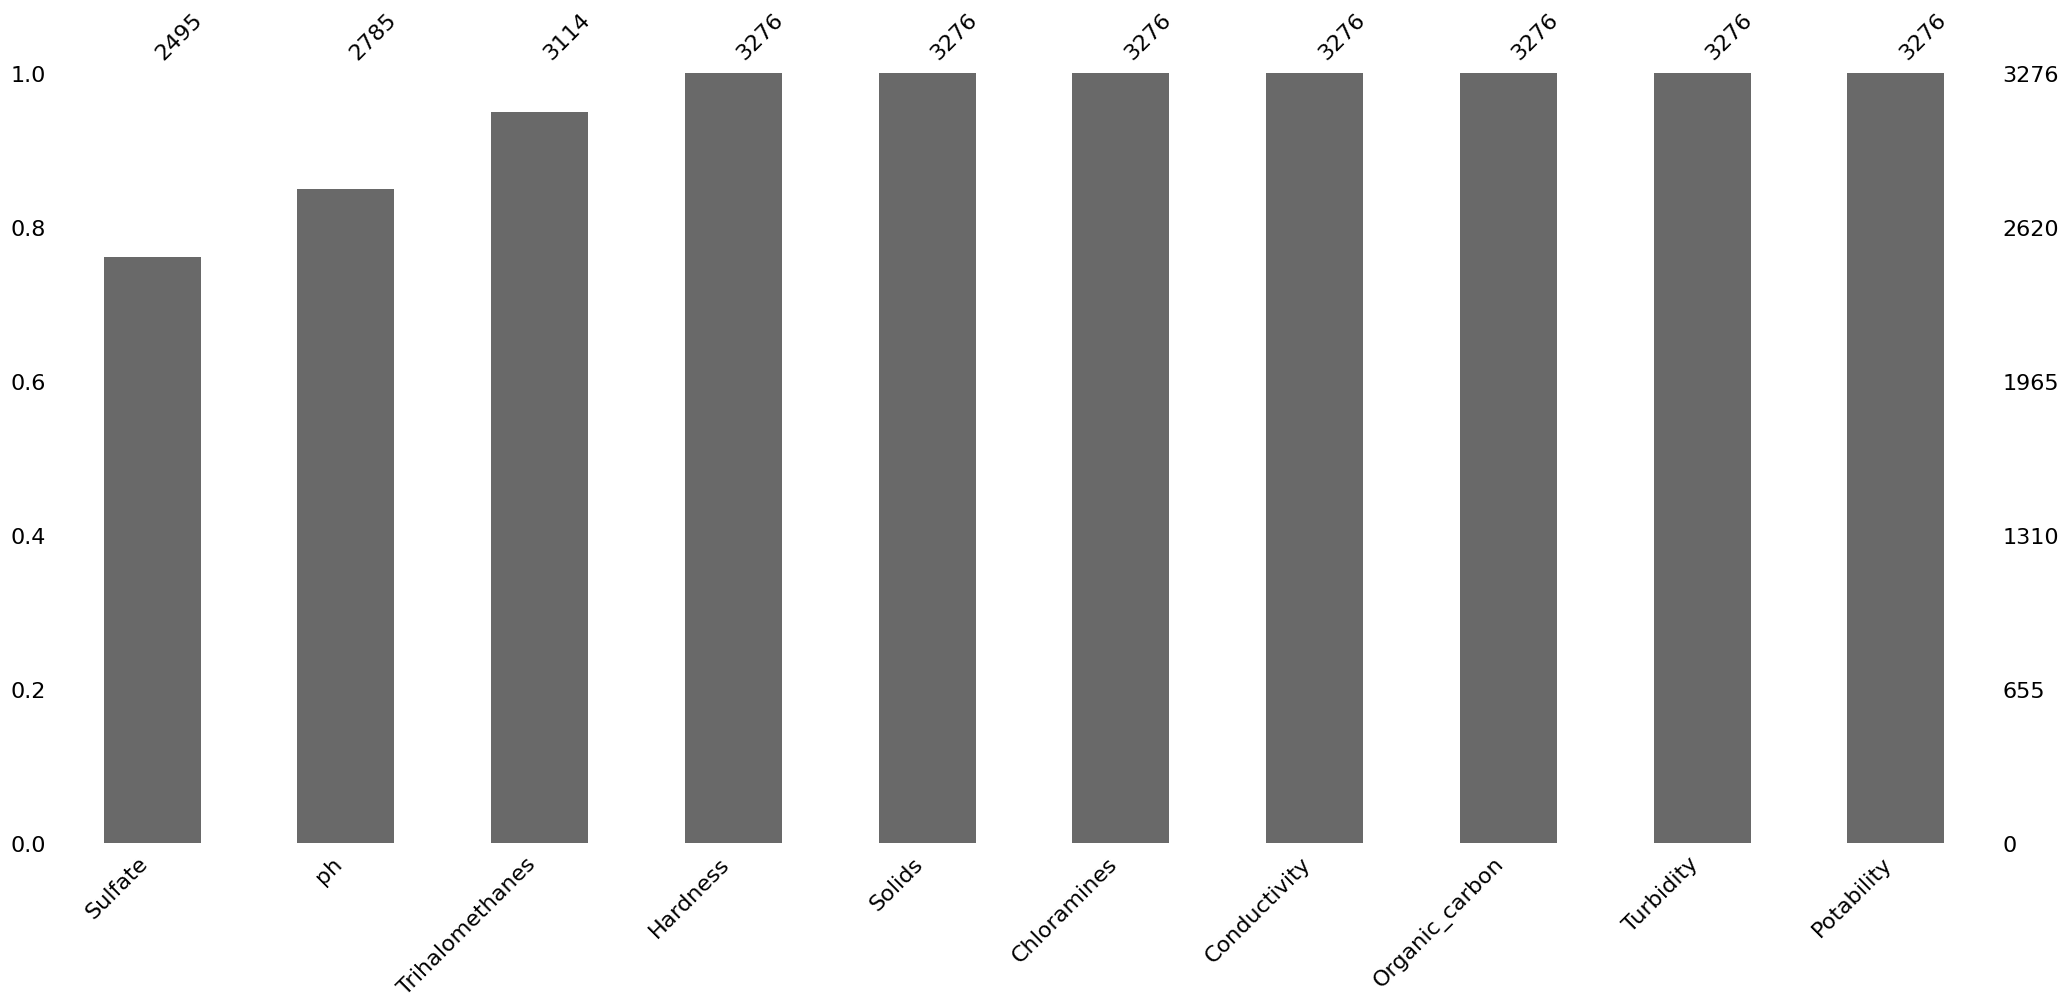

In [8]:
msno.bar(df, sort='ascending')

In [9]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [10]:
df.ph.mean()

7.080794504276835

In [11]:


print(f"nombre total d'entrées {df.shape[0]}")
print(f"nombre d'entrées avec un ph compris entre 6.5 et 8.5 {df[(df['ph'] >6.5) & (df['ph'] < 8.5)].shape[0]}")
print(f"percentage : {int(df[(df['ph'] >6.5) & (df['ph'] < 8.5)].shape[0]/df.shape[0]*100)}%")

nombre total d'entrées 3276
nombre d'entrées avec un ph compris entre 6.5 et 8.5 1328
percentage : 40%


In [12]:
df.Potability.value_counts(normalize=True)

Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

In [13]:
# import tensorflow.keras as keras
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from keras.wrappers.scikit_learn import KerasRegressor


In [14]:
clean_df = df.copy()

## Veille

MLflow est une plateforme open-source destinée à gérer le cycle de vie des modèles de machine learning (ML). 

Depuis sa création par Databricks en 2018, MLflow est devenu un outil crucial pour les professionnels des données souhaitant standardiser et optimiser leurs workflows ML.

Fonctionnalités Principales :

- Tracking : Suivi des expériences et des résultats associés, permettant de comparer facilement différentes exécutions et hyperparamètres.

- Projects : Organisation des projets ML avec des conventions spécifiques, assurant une reproductibilité des environnements et des configurations.

- Models : Gestion et déploiement des modèles ML à l’aide de formats standardisés comme MLflow Model, qui peuvent être intégrés avec différents frameworks de déploiement.

- Registry : Un référentiel centralisé pour la version et le stockage des modèles, facilitant la collaboration et le contrôle des versions.

## Features selection

### Building Pipeline

In [17]:
clean_df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [18]:
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler()) # RobustScaler/StandardScaler/MinMaxScaler
]) # passthrough/drop

preproc_df = pd.DataFrame(preprocessor.fit_transform(clean_df.drop(columns=["Potability"])) \
    , columns = clean_df.drop(columns=["Potability"]).columns)

In [19]:
### VarianceThreshold

In [20]:
pd.options.display.float_format = '{:.2f}'.format
preproc_df.var(axis=0)

ph                0.85
Hardness          0.68
Solids            0.56
Chloramines       0.63
Sulfate           1.18
Conductivity      0.48
Organic_carbon    0.54
Trihalomethanes   0.62
Turbidity         0.54
dtype: float64

Toutes passes mais cela confirme également les inquiétudes sur le dataset en un sens.

### SelectKbest

In [21]:
from sklearn.feature_selection import f_classif
from functions import load_best_model, save_model_if_best, variance_threshold_selector, KBest_selector, countplot_with_bins
f_classif(preproc_df, clean_df.Potability)

(array([0.02974052, 0.62692844, 3.73206243, 1.85229631, 1.37330748,
        0.2163261 , 2.94952328, 0.15527689, 0.00818029]),
 array([0.86309096, 0.42854159, 0.05346364, 0.17361022, 0.24132969,
        0.64188455, 0.08599746, 0.69356839, 0.92793916]))

In [22]:
preproc_df_with_y = preproc_df.copy()
preproc_df_with_y['Potability'] = clean_df.Potability.copy()
# On regarde les 3 features les moins impactantes d'après l'outil
print('Rassurez vous, aucune colonne n\'a été maltraité pendant cette opération')
KBest_selector(preproc_df_with_y, target_name = 'Potability', k=7)


Rassurez vous, aucune colonne n'a été maltraité pendant cette opération
columns dropped : ['ph', 'Turbidity']


,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Potability
0,0.20,-0.01,0.09,1.06,1.23,-0.85,1.02,0
1,-1.70,-0.20,-0.25,0.00,1.47,0.21,-0.51,0
2,0.68,-0.09,1.08,0.00,-0.03,0.59,-0.01,0
3,0.44,0.09,0.47,0.72,-0.51,0.94,1.68,0
4,-0.40,-0.25,-0.29,-0.69,-0.20,-0.59,-1.73,0
...,...,...,...,...,...,...,...,...
3271,-0.08,2.28,0.02,0.81,0.90,-0.07,0.00,1
3272,-0.09,-0.31,0.47,0.00,-0.25,1.27,0.00,1
3273,-0.53,1.05,0.11,0.00,0.09,-0.71,0.16,1
3274,0.84,-0.77,-0.42,0.00,-0.16,-0.68,0.54,1


### VIF


In [23]:
X = preproc_df_with_y.drop(columns="Potability")
y = preproc_df_with_y.Potability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
    random_state=42) # np.random.randint(1, 20001) 42

X_train_selected = pd.DataFrame(preprocessor.fit_transform(X_train),
        columns=preprocessor.get_feature_names_out())
X_test_selected = pd.DataFrame(preprocessor.fit_transform(X_test),
        columns=preprocessor.get_feature_names_out())

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = list(X_train_selected)
vif_data["VIF"] = [variance_inflation_factor(X_train_selected, i)
                          for i in range(len(X_train_selected.columns))]

print('VIF (facteur d\'inflation de la variance)')
print(vif_data)

VIF (facteur d'inflation de la variance)
           feature  VIF
0               ph 1.01
1         Hardness 1.02
2           Solids 1.04
3      Chloramines 1.01
4          Sulfate 1.04
5     Conductivity 1.00
6   Organic_carbon 1.00
7  Trihalomethanes 1.00
8        Turbidity 1.01


## Deep Learning

In [25]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
# mlflow server --host 127.0.0.1 --port 5000

In [26]:
def create_model():
    model = models.Sequential([
        layers.Dense(1, activation='sigmoid', input_dim=9),
        layers.Dense(25, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')

        # Output layer with sigmoid activation for binary classification
    ])
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model




to_scale = df.drop(columns=['Potability']).columns
select_features = to_scale  # + to_ordinal_encode

X = df[select_features]
y = df['Potability']

model_name = 'sequential_test'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y) \

# Building imputing Pipeline for data balancing
imputer_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

X_train_imputed = imputer_pipeline.fit_transform(X_train)
X_train_resampled, y_train_resampled = ADASYN().fit_resample(X_train_imputed, y_train) # ADASYN()


preprocessor = Pipeline([
    ('imputer', imputer_pipeline),
    ('robust_scaler', RobustScaler()) # RobustScaler/StandardScaler/MinMaxScaler
]) # passthrough/drop

adam_opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
es = callbacks.EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

checkpoint_cb = callbacks.ModelCheckpoint('model_checkpoint.h5', save_best_only=False)

mlflow.set_experiment(experiment_id="892102606047290498") # "0" # mlflow.set_experiment("Waterflow final model")
mlflow.autolog()

# Create and train models tracked on mlflow.
with mlflow.start_run(run_name="sequential_deep_learning_model"):
    keras_wrapper = KerasClassifier(model=create_model, epochs=10000, batch_size=16, callbacks=[es], verbose=0)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('keras_model', keras_wrapper)
    ])
    pipeline.fit(X_train_resampled, y_train_resampled)

    y_pred = pipeline.predict(X_test)
    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Log recall manually if needed
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.set_tag("Project", "wateflow")
    signature = infer_signature(X_train, pipeline.predict(X_train))
    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="waterflow_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-waterflow",
    )

# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

predictions = loaded_model.predict(X_test)

df_columns = X_test.columns

result = pd.DataFrame(X_test, columns=df_columns)
result["actual_class"] = y_test
result["predicted_class"] = predictions

result[:10]

2024/05/28 11:36:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/28 11:36:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/05/28 11:36:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/05/28 11:36:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/05/28 11:36:05 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/05/28 11:36:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/05/28 11:36:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provi

INFO:tensorflow:Assets written to: /tmp/tmpn1x3o4tu/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpn1x3o4tu/model/data/model/assets


INFO:tensorflow:Assets written to: ram://1e5a6809262c427791e441e04584c94d/assets


INFO:tensorflow:Assets written to: ram://1e5a6809262c427791e441e04584c94d/assets
/home/julienrm/.pyenv/versions/3.8.12/envs/waterflow/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Accuracy: 0.5167853509664293


/home/julienrm/.pyenv/versions/3.8.12/envs/waterflow/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


INFO:tensorflow:Assets written to: ram://2f62dfd41eb041a4bbba680fe0245288/assets


INFO:tensorflow:Assets written to: ram://2f62dfd41eb041a4bbba680fe0245288/assets
Successfully registered model 'tracking-waterflow'.
2024/05/28 11:37:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-waterflow, version 1
Created version '1' of model 'tracking-waterflow'.
2024-05-28 11:37:32.334741: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://63765d9d9116432aa79f5fb58d18e39c: INVALID_ARGUMENT: ram://63765d9d9116432aa79f5fb58d18e39c is a directory.
/home/julienrm/.pyenv/versions/3.8.12/envs/waterflow/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,actual_class,predicted_class
3036,8.86,194.56,20231.52,6.52,332.35,476.23,17.89,52.91,4.58,0,1
2226,7.89,207.82,12359.63,7.38,340.98,499.36,14.05,97.63,5.43,0,1
2711,7.65,239.49,15326.93,8.93,373.44,425.34,17.88,NaN,4.04,1,1
1984,7.73,189.51,47022.75,8.23,287.09,567.72,14.98,71.21,3.51,1,1
585,6.67,222.49,25319.91,4.97,339.06,318.56,19.37,72.72,3.93,0,1
2940,3.96,173.03,24028.41,8.01,391.00,444.79,19.95,59.83,4.09,0,0
2335,4.76,150.07,19197.11,7.94,374.48,400.45,11.13,69.26,4.58,1,0
2774,7.29,216.61,18979.98,7.67,358.98,384.69,14.16,53.31,3.63,1,1
444,7.70,234.64,22057.38,8.12,NaN,397.40,14.90,50.92,3.03,0,1
1864,NaN,233.69,17317.69,8.95,264.92,311.97,10.75,108.59,4.24,0,0


In [35]:
model_info.model_uri

'runs:/96769e9236bb446aa8a9bd8ae214700d/waterflow_model'

In [34]:
X_train.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object')

In [ ]:
print("Accuracy:", accuracy)

Accuracy: 0.6327568667344863


In [ ]:
mlflow.end_run()

<img src="../data/img/Capture d'écran 2024-05-27 13540646.png" alt="model result" width="42%">

Le modèle dépasse les résultats de la baseline avec des peak d'accuracy à 0.68 sur certains entraînements sans être suffisament fiable pour être utilisé pour estimer avec suffisament de fiabilité la potabilité de l'eau.